### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda
Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))

# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))


attack = "fully"
mnist_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
# Loading Data
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

### Projected Gradient Descent
Projected Gradient Descent is an optimization algorithm that iteratively computes the gradient of the loss and perturbs the image in the direction of the loss gradient. This algorithm has unique hyperparameters. We have a value $α$ which controls the step size the image moves along the gradient, but we also have something known as the $ϵ$-ball. Around the image in the vector space exists a multi dimensional threshold where the image is still percievable to humans. We clip the perturbed output image such that it always exists within this epsilon ball, and we can expand or shrink the epsilon to tune results.

\begin{array}{l}
\textbf{while } t < \text{ iterations:} \\
\hspace{2em} x_{t+1} = Clip(x_t + \alpha \cdot sign(\nabla_x J(\theta, x_t, y)), x, x + \epsilon)
\end{array}

PGD uses uses $L^∞$ Norm Perturbations and MUST be used against  classifiers.

In [6]:
def test_pgd(model, test_loader, epsilon, alpha):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Epsilon: {epsilon}, Correct: {correct}")
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            

            output_final, perturbed_data = pgd_attack(image, model, init_pred, epsilon, alpha)
            _, final_pred = torch.max(output_final.data, 1)
            if torch.equal(final_pred, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            print(f"{correct}/{total}")
            total +=1 
            # break
        # break

    accuracy = correct / total
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

In [7]:
# MNIST
accuracy, examples = test_pgd(mnist_resnet_model, test_loader_mnist, .25, 0.1 )
print(accuracy)

Batch: 1, Epsilon: 0.25, Correct: 0
0/0
0/1
0/2
0/3
0/4
0/5
0/6
0/7
0/8
0/9
0/10
0/11
0/12
1/13
1/14
1/15
1/16
2/17
2/18
3/19
3/20
3/21
3/22
3/23
3/24
3/25
3/26
3/27
3/28
3/29
3/30
3/31
3/32
3/33
3/34
3/35
3/36
3/37
3/38
3/39
3/40
3/41
3/42
3/43
3/44
3/45
3/46
3/47
3/48
3/49
3/50
3/51
3/52
3/53
4/54
5/55
6/56
6/57
6/58
6/59
6/60
6/61
6/62
6/63
7/64
7/65
7/66
7/67
7/68
8/69
8/70
9/71
9/72
9/73
9/74
10/75
10/76
10/77
10/78
10/79
10/80
10/81
10/82
10/83
11/84
11/85
11/86
11/87
11/88
11/89
11/90
11/91
11/92
11/93
11/94
11/95
11/96
12/97
12/98
13/99
14/100
14/101
14/102
15/103
15/104
15/105
15/106
15/107
15/108
16/109
16/110
16/111
16/112
16/113
17/114
18/116
19/117
19/118
19/119
19/120
19/121
19/122
19/123
19/124
19/125
19/126
19/127
19/128
19/129
19/130
19/131
19/132
20/133
20/134
20/135
20/136
20/137
21/138
21/139
21/140
21/141
21/142
21/143
21/144
21/145
22/146
22/147
22/148
22/149
22/150
22/151
22/152
22/153
22/154
22/155
22/156
22/157
22/158
22/159
22/160
22/161
23/162
24/163
24/164
2

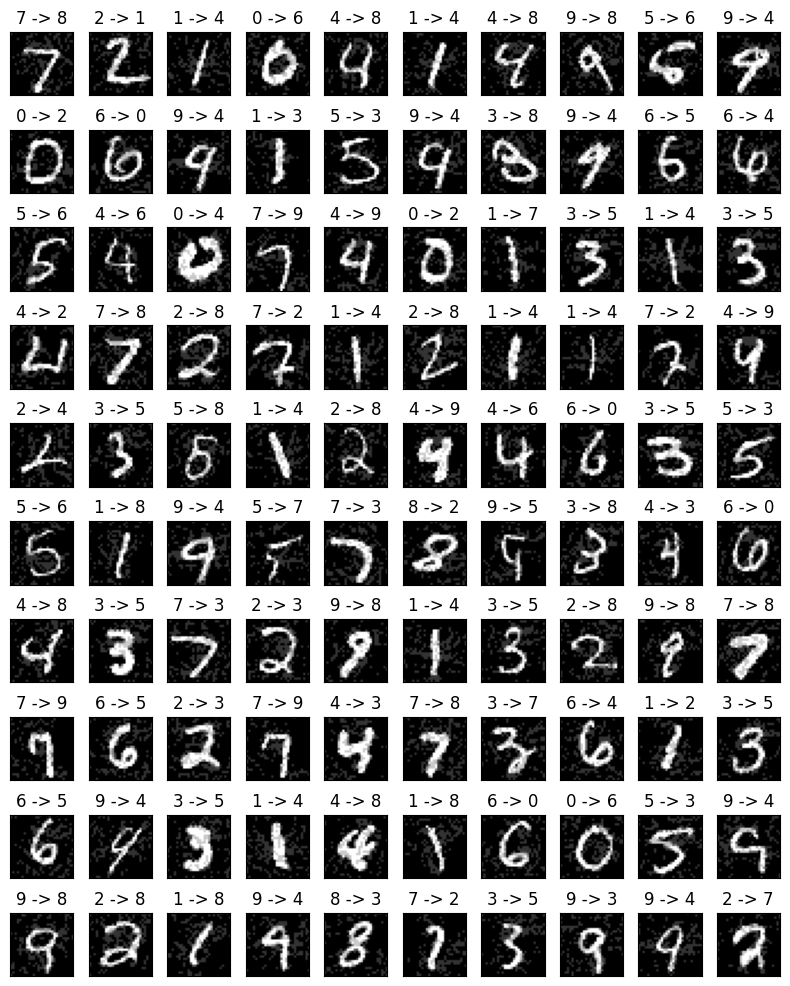

In [8]:
# MNIST Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [9]:
# CIFAR10
accuracy, examples = test_pgd(cifar_resnet_model, test_loader_cifar10, .25, 0.00625)
print(accuracy)

Batch: 1, Epsilon: 0.25, Correct: 0
0/0
0/2
0/3
0/5
0/6
0/7
0/8
0/9
0/10
0/11
0/12
0/13
0/14
0/15
0/16
0/17
0/18
0/19
0/20
0/22
0/23
0/25
0/26
0/27
0/28
0/29
0/30
0/31
0/32
0/34
0/36
0/37
0/38
0/39
0/40
0/41
0/43
0/45
0/46
0/48
0/49
1/50
1/51
1/53
1/54
1/55
1/56
2/60
2/62
2/63
2/64
2/66
2/67
2/68
2/69
2/72
2/73
2/74
3/75
3/77
3/78
3/79
3/80
3/81
4/82
4/83
4/84
4/86
5/88
5/89
5/90
6/92
6/93
6/94
6/95
6/96
7/98
7/99
7/100
7/101
7/102
7/103
7/104
8/105
8/106
8/107
8/108
8/109
8/110
9/111
9/112
9/113
9/114
9/115
9/116
9/117
9/120
9/122
9/123
9/124
9/126
9/127
9/130
9/131
9/132
10/133
10/134
10/135
10/136
10/137
10/138
11/141
11/142
11/144
11/145
11/146
11/148
11/149
11/150
11/151
11/152
11/153
11/154
11/155
11/156
11/157
11/159
11/161
11/163
11/165
11/166
11/167
11/169
11/170
11/172
11/173
11/174
12/175
12/176
12/178
12/179
12/180
12/181
12/182
12/184
12/185
12/186
12/190
12/191
12/192
12/193
12/194
12/196
12/197
12/198
12/199
12/200
12/202
12/203
12/204
12/205
12/206
12/207
12/208
12/209


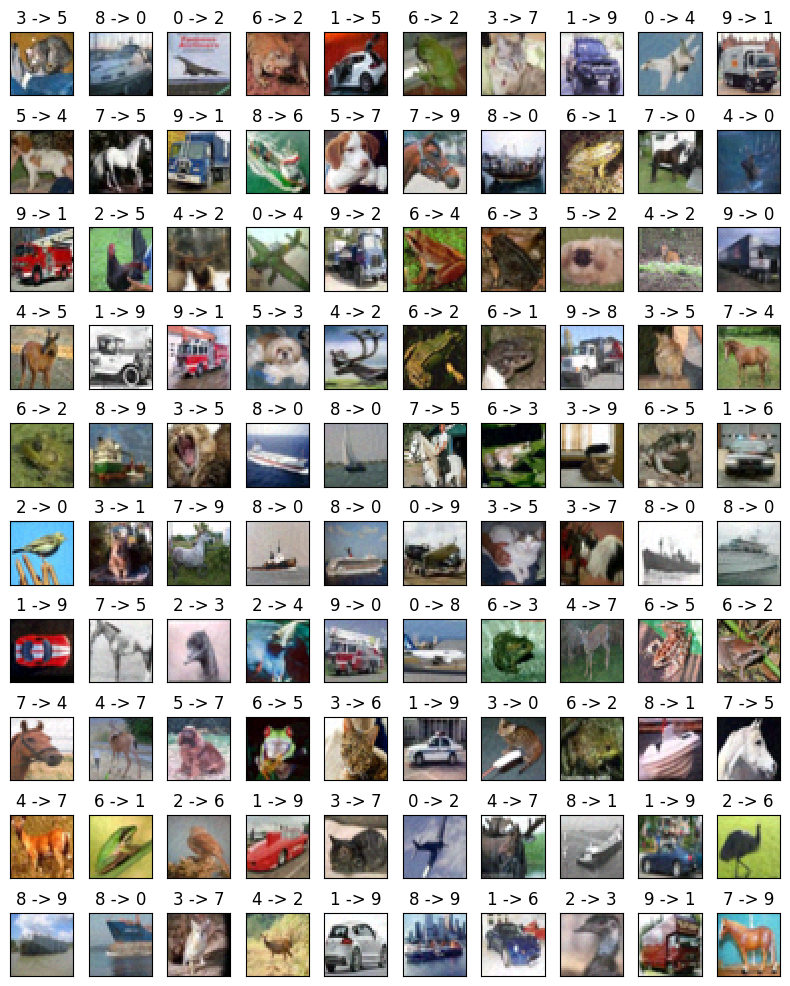

In [10]:
# CIFAR10/SVHN Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255.0  # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [11]:
# SVHN
accuracy, examples = test_pgd(svhn_resnet_model, test_loader_svhn, .25, 0.00625)
print(accuracy)

Batch: 1, Epsilon: 0.25, Correct: 0
0/0
0/1
0/2
0/3
0/4
0/5
0/6
0/7
0/8
0/9
0/11
0/12
0/13
0/14
0/15
0/16
0/17
1/18
2/19
3/20
4/21
4/22
5/24
6/25
7/26
7/27
7/28
7/29
7/31
7/32
7/33
7/34
8/35
8/36
9/37
9/38
9/39
9/41
9/42
9/43
9/44
9/46
10/47
11/48
12/49
12/50
13/51
14/52
14/53
14/54
14/58
14/59
14/60
14/62
14/63
14/64
14/65
14/66
14/67
14/68
14/69
14/70
14/71
14/72
14/73
14/74
14/75
14/76
14/77
14/78
14/79
14/80
14/81
14/82
14/83
14/84
14/85
14/86
14/87
14/88
14/89
14/90
14/91
14/93
14/94
14/95
14/97
14/98
14/99
15/100
16/101
17/102
17/103
17/104
18/105
18/106
18/107
18/108
18/109
19/110
19/111
19/112
20/114
20/115
21/116
21/118
22/119
22/120
22/121
23/122
24/123
24/125
25/127
25/128
26/129
26/130
26/131
26/133
26/134
27/135
27/136
27/137
27/138
28/141
29/142
29/143
30/144
31/145
31/146
31/147
31/148
32/149
32/150
33/151
33/152
33/153
33/154
33/155
33/157
33/158
33/159
33/160
33/161
34/163
34/164
34/165
34/166
35/167
35/168
35/169
35/170
35/171
35/172
35/173
35/174
35/175
35/176
35/177

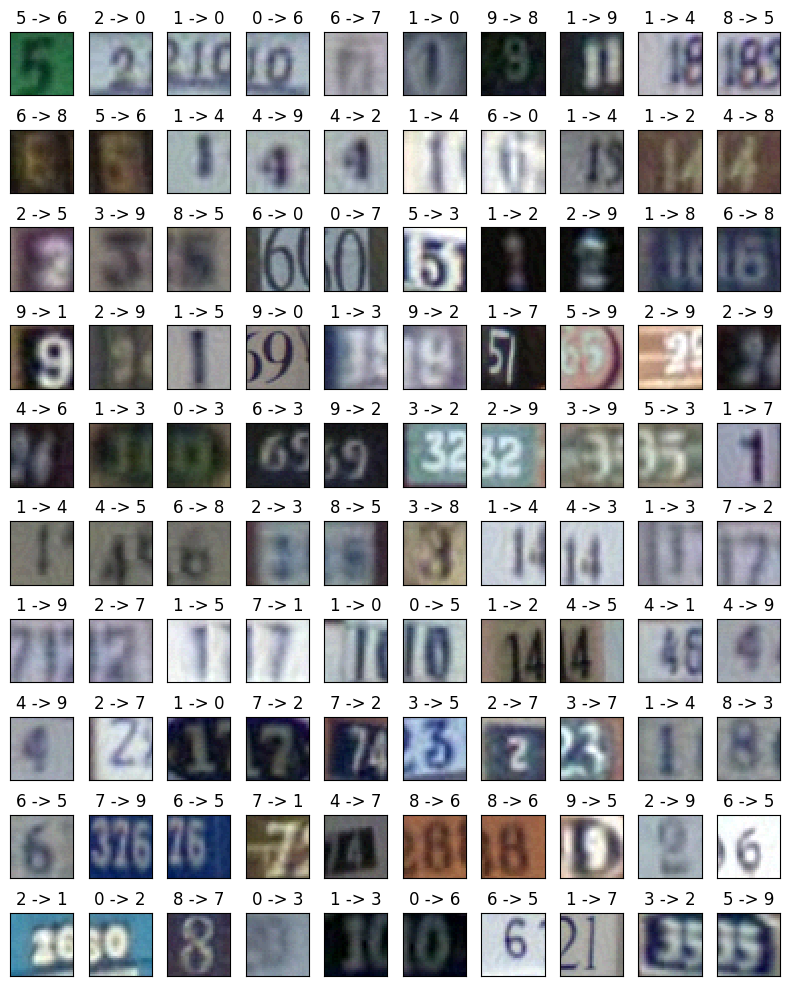

In [12]:
# CIFAR10/SVHN Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255.0  # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()